# 3D visualisation of microscopy images

In [2]:
from pathlib import Path

from confocal_microscopy.files import ims
from confocal_microscopy.color import channels
import matplotlib.pyplot as plt
import ipywidgets
from skimage import exposure
import numpy as np
import vtk
from vtk.util import numpy_support as vtk_np
from skimage import io

In [2]:
exposure.equalize_adapthist?

In [3]:
%matplotlib notebook

In [4]:
def maximum_intensity_projection(image, axis=0):
    return image.max(axis=axis)

In [5]:
image_path = Path("/home/yngve/Documents/Fish 1 complete/Cancer region/Blood vessels 3d stack/fast_2020-09-02_Federico s_10.41.10_JFM9CC2.ims")

image = ims.load_image_stack(image_path, resolution_level=2)

In [6]:
vtk_data = vtk_np.numpy_to_vtk(image.ravel(), array_type=vtk.VTK_DOUBLE)

In [7]:
from tqdm import trange
vtk_image = vtk.vtkImageData()
vtk_image.SetDimensions(image.shape)
vtk_image.AllocateScalars(vtk.VTK_DOUBLE, 1)
for i in trange(image.shape[0]):
    for j in range(image.shape[1]):
        for k in range(image.shape[2]):
            vtk_image.SetScalarComponentFromDouble(i, j, k, 0, image[i, j, k])

100%|██████████| 64/64 [00:06<00:00,  9.38it/s]


In [8]:
filename = "downsampled.vti"

writer = vtk.vtkXMLImageDataWriter()
writer.SetFileName(filename)
writer.SetInputData(vtk_image)
writer.Write()


1

In [9]:
# Read the file (to test that it was written correctly)
reader = vtk.vtkXMLImageDataReader()
reader.SetFileName(filename)
reader.Update()

# Convert the image to a polydata
imageDataGeometryFilter = vtk.vtkImageDataGeometryFilter()
imageDataGeometryFilter.SetInputConnection(reader.GetOutputPort())
imageDataGeometryFilter.Update()

mapper = vtk.vtkPolyDataMapper()
mapper.SetInputConnection(imageDataGeometryFilter.GetOutputPort())

actor = vtk.vtkActor()
actor.SetMapper(mapper)
actor.GetProperty().SetPointSize(3)

# Setup rendering
renderer = vtk.vtkRenderer()
renderer.AddActor(actor)
renderer.SetBackground(1,1,1)
renderer.ResetCamera()

renderWindow = vtk.vtkRenderWindow()
renderWindow.AddRenderer(renderer)

renderWindowInteractor = vtk.vtkRenderWindowInteractor()

renderWindowInteractor.SetRenderWindow(renderWindow)
renderWindowInteractor.Initialize()
renderWindowInteractor.Start()

In [10]:
from skimage import io

In [11]:
io.imsave("image.tiff", image)

<ipython-input-11-5b7e8993b5bd>:1: UserWarning: image.tiff is a low contrast image
  io.imsave("image.tiff", image)


In [12]:
io.imsave?

In [38]:
image_path = Path("/home/yngve/Documents/Fish 1 complete/Cancer region/Blood vessels 3d stack/fast_2020-09-02_Federico s_10.41.10_JFM9CC2.ims")

image = ims.load_image_stack(image_path, resolution_level=3)
orig_image = image
k = 10
image = exposure.equalize_adapthist(image, kernel_size=(k, k, k/5))
image = image.astype(float)
image = np.minimum(image, np.percentile(image, 99))
image -= image.min()
image /= image.max()

In [40]:
plt.imshow(image[3])


In [28]:
io.imsave("image_eq.tiff", (image*orig_image.max()).astype(orig_image.dtype))

<ipython-input-28-3c76dc8ab4be>:1: UserWarning: image_eq.tiff is a low contrast image
  io.imsave("image_eq.tiff", (image*orig_image.max()).astype(orig_image.dtype))


<IPython.core.display.Javascript object>


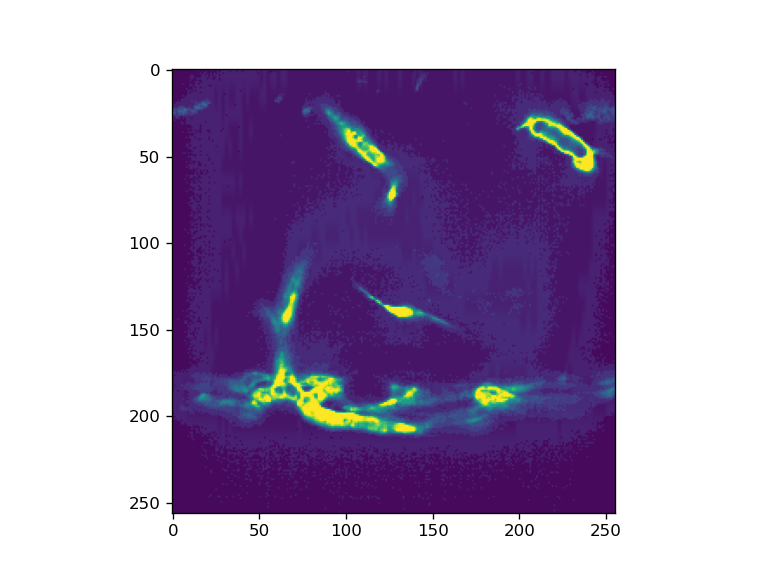

In [1]:
from numba import njit, prange

forward_difference = np.diff(image, axis=0)
backward_difference = np.diff(image[::-1], axis=0)[::-1]

NameError: name 'np' is not defined

In [41]:
from scipy.ndimage import sobel
from tqdm import trange

denoised = image


for i in trange(1):
    derivs = [
        sobel(denoised, axis=i) for i in range(image.ndim)
    ]
    denoised = denoised + sum(2*x/(1 + x**2) for x in derivs)/3

100%|██████████| 1/1 [00:00<00:00,  6.58it/s]


<IPython.core.display.Javascript object>


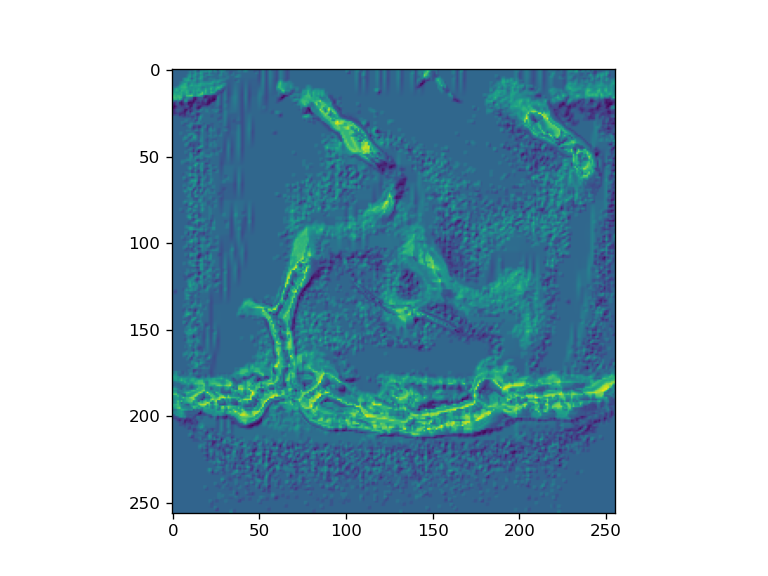

In [43]:
plt.figure()
plt.imshow(denoised[5])

<IPython.core.display.Javascript object>


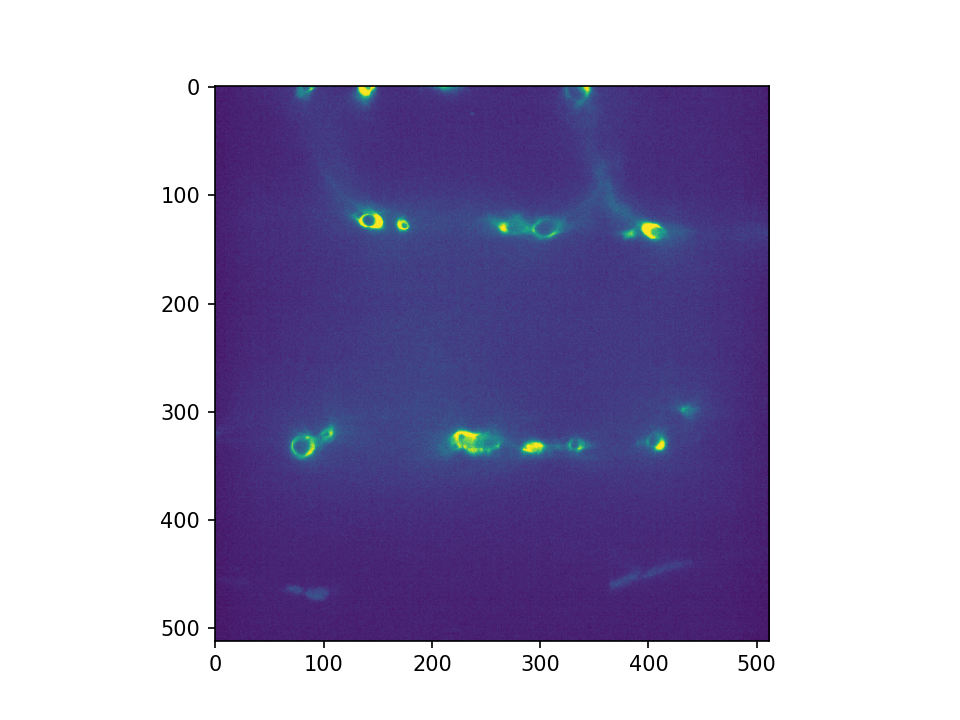

interactive(children=(IntSlider(value=31, description='slice', max=63), Output()), _dom_classes=('widget-inter…

In [59]:
fig, ax = plt.subplots()

@ipywidgets.interact()
def replot(slice=(0, image.shape[0]-1)):
    ax.clear()
    ax.imshow(image[slice], vmin=0, vmax=1)
    

In [41]:
from mayavi import mlab
mlab.init_notebook()

Notebook initialized with ipy backend.


In [76]:
mlab.clf()
figure = mlab.figure(size=(800, 800), bgcolor=(0, 0, 0))
th = filters.threshold_otsu(image)
color = cm.magma(th)[:3]
mlab.contour3d((image > th).astype(float), colormap="magma")
mlab.volume_slice(image, colormap="magma")
mlab.volume_slice(image, colormap="magma", plane_orientation='y_axes')
mlab.volume_slice(image, colormap="magma", plane_orientation='z_axes')

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x03 \x00\x00\x03 \x08\x02\x00\x00\x00T\x12\x91?\x00\…

In [30]:
from skimage import filters


0.095703125

<IPython.core.display.Javascript object>


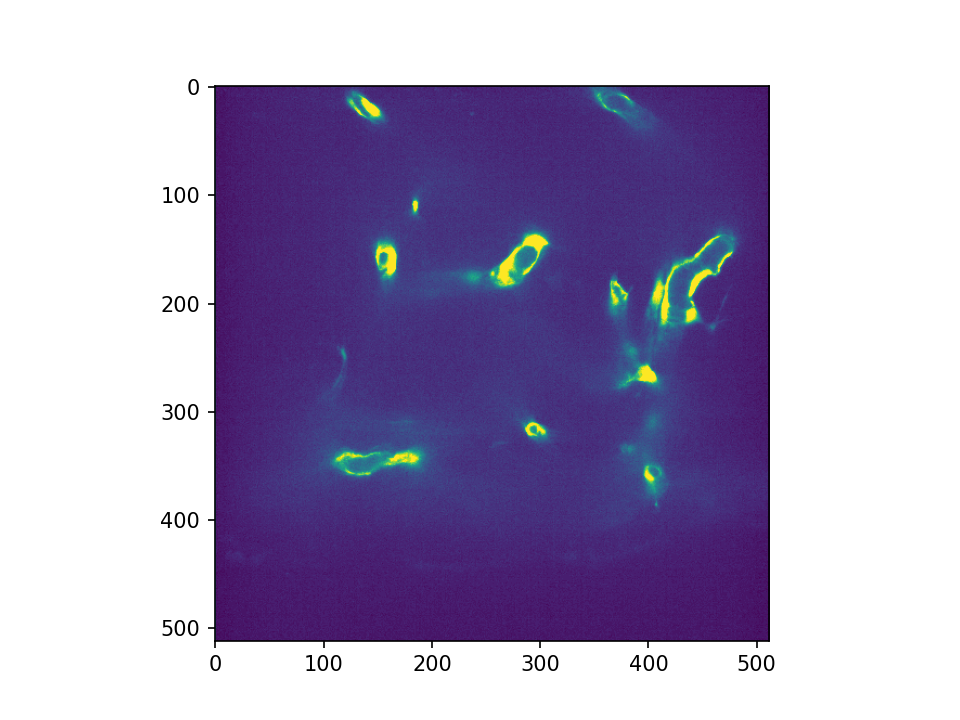

(array([ 1683956., 12654526.,  1488916.,   247979.,   196426.,   123507.,
           65813.,    65350.,    48063.,   202680.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

In [54]:
plt.hist(image.ravel(), bins=10)